In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from kerashypetune import KerasGridSearch

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
### READ DATA ###

df = pd.read_csv('BeijingPM2.csv')
df['date'] = pd.to_datetime(df[['year','month','day','hour']])
df['cbwd'] = df.cbwd.factorize()[0]
df['pm2.5'] = df['pm2.5'].interpolate(method='linear', limit_direction='both')

print(df.shape)
df.head()

(43824, 14)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,0,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,0,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,0,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,0,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,0,12.97,0,0,2010-01-01 04:00:00


In [3]:
### TRAIN, VALIDATION, TEST TEMPORAL SPLIT ###

columns = ['DEWP','TEMP','PRES','Iws','Is','Ir','cbwd']

y_train = df[df.year <= 2012]['pm2.5'].copy().values
train_date = df[df.year <= 2012].date.values
x_train = df[df.year <= 2012][columns].copy()

y_val = df[df.year == 2013]['pm2.5'].copy().values
val_date = df[df.year == 2013].date.values
x_val = df[df.year == 2013][columns].copy()

y_test = df[df.year == 2014]['pm2.5'].copy().values
test_date = df[df.year == 2014].date.values
x_test = df[df.year == 2014][columns].copy()

print(x_train.shape, x_val.shape, x_test.shape)

(26304, 7) (8760, 7) (8760, 7)


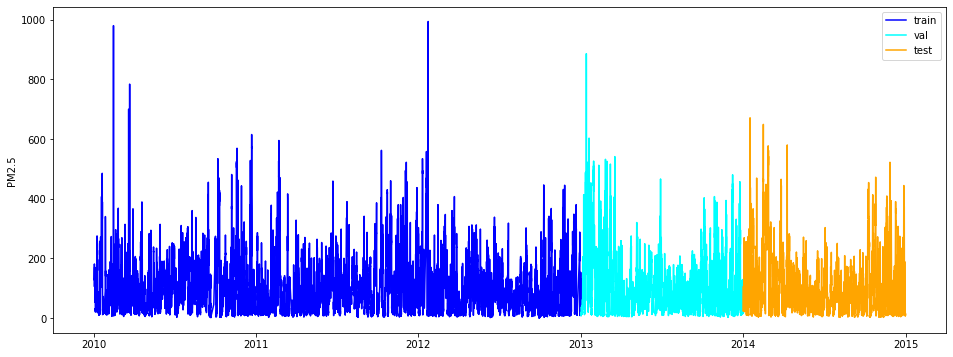

In [4]:
### PLOT TRAIN, VALIDATION, TEST ###

plt.figure(figsize=(16,6))

plt.plot(train_date, y_train, label='train', c='blue')
plt.plot(val_date, y_val, label='val', c='cyan')
plt.plot(test_date, y_test, label='test', c='orange')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [5]:
### UTILITY FUNCTION FOR SEQUENCES GENERATION ###

sequence_length = 24*2

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [6]:
### GENERATE SEQUENCES ###

X_train, X_val, X_test = [], [], []

for sequence in gen_sequence(x_train, sequence_length, columns):
    X_train.append(sequence)
    
for sequence in gen_sequence(x_val, sequence_length, columns):
    X_val.append(sequence)
    
for sequence in gen_sequence(x_test, sequence_length, columns):
    X_test.append(sequence)
    
X_train, X_val, X_test = np.asarray(X_train), np.asarray(X_val), np.asarray(X_test)
print(X_train.shape, X_val.shape, X_test.shape)

(26256, 48, 7) (8712, 48, 7) (8712, 48, 7)


In [7]:
### UTILITY FUNCTIONS FOR TARGET SCALING ###

def scale_target(y, mean, std):
    return (y - mean)/std

def reverse_target(pred, mean, std): 
    return pred*std + mean

In [8]:
### SCALE TARGET ###

mean_train = y_train.mean()
std_train = y_train.std()

y_train_seq = scale_target(y_train[sequence_length:], mean_train, std_train)
y_val_seq = scale_target(y_val[sequence_length:], mean_train, std_train)
y_test_seq = scale_target(y_test[sequence_length:], mean_train, std_train)

print(y_train_seq.shape, y_val_seq.shape, y_test_seq.shape)

(26256,) (8712,) (8712,)


In [9]:
### SCALE SEQUENCES ###

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,len(columns))).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1,len(columns))).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1,len(columns))).reshape(X_test.shape)

In [10]:
### DEFINE MODEL ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(params):
    
    set_seed(33)
    
    inp = Input(shape=(sequence_length, len(columns)))

    x = GRU(params['units_gru'], return_sequences=True)(inp)
    x = AveragePooling1D(2)(x)
    x = Conv1D(params['units_cnn'], 3, 
               activation='relu', padding='same', 
               name='extractor')(x)
    x = Flatten()(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr=params['lr']), loss='mse')
    
    return model

In [11]:
param_grid = {
    'units_gru': [128, 64],
    'units_cnn': [64, 32],
    'lr': [1e-4, 1e-3],
    'batch_size': [512, 1024]
}

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
kgs = KerasGridSearch(get_model, param_grid, 
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train_seq, validation_data=(X_val, y_val_seq), callbacks=[es], epochs=50)


16 trials detected for ('units_gru', 'units_cnn', 'lr', 'batch_size')

***** (1/16) *****
Search({'units_gru': 128, 'units_cnn': 64, 'lr': 0.0001, 'batch_size': 512})
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
SCORE: 0.5623 at epoch 20

***** (2/16) *****
Search({'units_gru': 128, 'units_cnn': 64, 'lr': 0.0001, 'batch_size': 1024})
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
SCORE: 0.5856 at epoch 22

***** (3/16) *****
Search({'units_gru': 128, 'units_cnn': 64, 'lr': 0.001, 'batch_size': 512})
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
SCORE: 0.53744 at epoch 3

***** (4/16) *****
Search({'units_gru': 128, 'units_cnn': 64, 'lr': 0.001, 'batch_size': 1024})
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
SCORE: 0.55437 at epoch 4

***** (5/16) *****
Search({'units_gru': 128, 'units_cnn': 32, 'lr': 0.0001, 'batch_size': 512})
Rest

In [12]:
### MAKE PREDICTION ON TEST ###

pred = reverse_target(kgs.best_model.predict([X_test]).ravel(), mean_train, std_train)

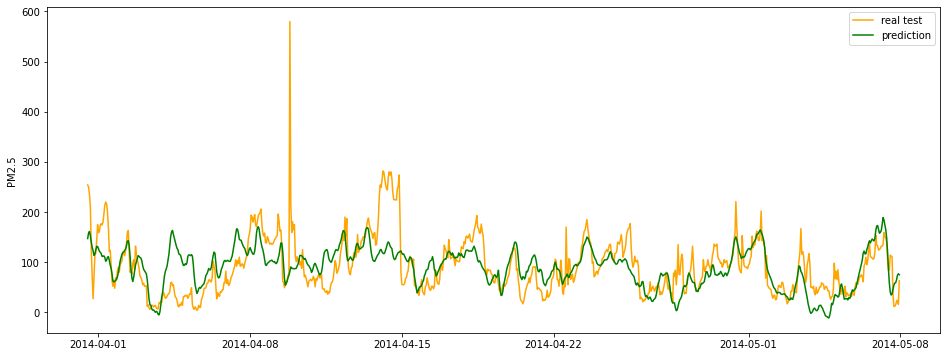

In [13]:
### PREDICTIONS vs REALITY ON TEST ###

plt.figure(figsize=(16,6))

start, end = 2100, 3000
plt.plot(test_date[sequence_length+start:end+sequence_length], y_test[sequence_length+start:end+sequence_length], 
         c='orange', label='real test')
plt.plot(test_date[sequence_length+start:end+sequence_length], pred[start:end], 
         c='green', label='prediction')
plt.legend(); plt.ylabel('PM2.5')
plt.show()

# INFERENCE ON PREDICTIONS

In [14]:
### UTILITY FUNCTIONS FOR GRADIENT IMPORTANCE AND ACTIVIATION MAPS GENERATION ### 


def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

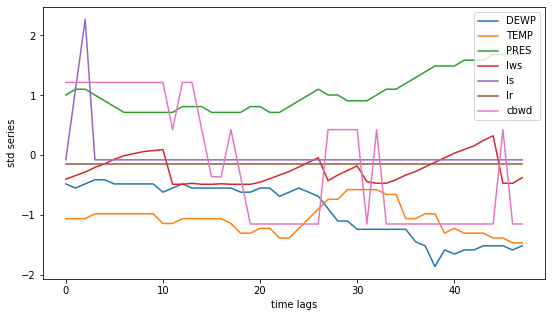

In [15]:
### DISPLAY INPUT SEQUENCE ###

id_ = 128

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
plt.ylabel('std series'); plt.xlabel('time lags'); plt.legend(columns)
plt.show()

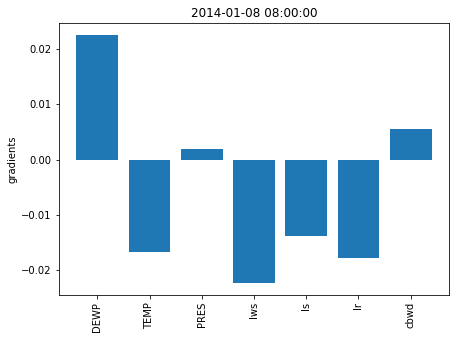

In [16]:
### GRADIENTS IMPORTANCE ###

grad_imp = gradient_importance(X_test[id_], kgs.best_model)

plt.figure(figsize=(7,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.show()

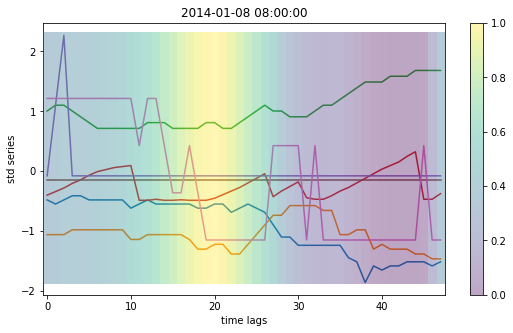

In [17]:
### GENERATE ACTIVATION ON INPUT SEQUENCE ###

activation = activation_grad(X_test[id_], kgs.best_model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
plt.ylabel('std series'); plt.xlabel('time lags'); plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
plt.show()